In [48]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii

In [70]:
#kaguya_file = '/scratch/arsanders/kaguyatc/TC2S2B0_01_03043N107E3384.img'
#kaguya_file = '/home/arsanders/testData/apollo/AS15-M-1450.lbl'
marci_file = '/home/arsanders/testData/marci/T02_001251_1292_MU_00N237W.IMG'
image_file = marci_file

In [71]:
header = pvl.load(marci_file)

In [72]:
with open(marci_file, 'rb') as f:
    try:
        image_offset = ((header["^IMAGE"]-1) * header["RECORD_BYTES"]) - (header['IMAGE']['SAMPLE_BITS']//8)
        f.seek(image_offset)
        b_image_data = f.read()
    except AttributeError:
        # If detached label, "^IMAGE" will be a list.
        image_file = os.path.dirname(marci_file) + "/" + header["^IMAGE"][0]
        image_offset = header["^IMAGE"][1].value
        with open(image_file, 'rb') as im_f:
            b_image_data = im_f.read()

In [73]:
n_lines = 100
line_length = header['IMAGE']['LINE_SAMPLES'] * (header['IMAGE']['SAMPLE_BITS']//8)

In [74]:
image_data = []
for j in range(n_lines):
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length], dtype=np.uint8, count=int(line_length))
    image_data.append(image_sample)
image_data = np.array(image_data)

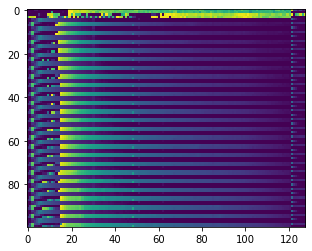

In [75]:
plt.imshow(image_data)

In [76]:
class RealIsisCubeLabelEncoder(pvl.encoder.IsisCubeLabelEncoder):    
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second

        time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time.encode('utf-8')

In [77]:
image_fn, image_ext = os.path.splitext(image_file)
mini_image_fn = image_fn + '_cropped' + image_ext
mini_image_bn = os.path.basename(mini_image_fn)

# Overwrite the number of lines in the label
header['IMAGE']['LINES'] = n_lines

if marci_file != image_file:
    # If detached label, point the mini label to the mini image
    #header['^IMAGE'] = [mini_image_bn, pvl._collections.Units(1, 'BYTES')]
    header['FILE_NAME'] = mini_image_bn
else:
    # If attached label, calculate the new offset
    header['^IMAGE'] = pvl._collections.Units(len(pvl.dumps(header, cls=RealIsisCubeLabelEncoder)), 'BYTES')

In [78]:
label_fn, label_ext = os.path.splitext(marci_file)
out_label = label_fn + '_cropped' + label_ext

pvl.dump(header, out_label, cls=RealIsisCubeLabelEncoder)

In [79]:
with open(mini_image_fn, 'ab+') as f:
    b_reduced_image_data = image_data.tobytes()
    #f.seek(0, 2)
    f.write(b_reduced_image_data)